# Artificial Intelligence within the Healthcare System (M7016H) - Project

**Breast Cancer Detection**

Source: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

## Imports

In [16]:
import os, torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from zipfile import ZipFile

from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import ConcatDataset, random_split, DataLoader

from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    det_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Initialize device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing

### Unzipping

In [3]:
try:
    with ZipFile("data.zip", 'r') as f:
        f.extractall()
    
    os.remove("data.zip")

except:
    pass

### Load & Transform Images

In [4]:
IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# Print Sets Sizes
_, train_samples = np.unique(train_dataset.targets, return_counts=True)
_, test_samples = np.unique(test_dataset.targets, return_counts=True)

train_samples = np.append(train_samples, np.sum(train_samples))
test_samples = np.append(test_samples, np.sum(test_samples))

values = [train_samples, test_samples, train_samples + test_samples]
samples_names = ['Training', 'Test', 'Total']
samples_labels = ['Benign', 'Malignant', 'Total']

no_samples_df = pd.DataFrame(data=values, index=samples_names, columns=samples_labels)
no_samples_df = no_samples_df.reset_index(names='Set')
no_samples_df = no_samples_df.style.hide(axis='index')

no_samples_df

### Augment Training Data

In [5]:
transform_aug = transforms.Compose([
    transforms.Resize(size=IMAGE_SHAPE),
    transforms.RandomResizedCrop(size=IMAGE_SHAPE, antialias=True),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=(3, 3))
])

augmented_train_dataset = datasets.ImageFolder(root='data/train', transform=transform_aug)
train_val_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

### Generate Dataset Splits

In [6]:
train_val_len = len(train_val_dataset)

test_len = len(test_dataset)
val_len = test_len
train_len = train_val_len - test_len

train_dataset, val_dataset = random_split(train_val_dataset, [train_len, val_len])

# Print Sets Sizes
values = np.zeros(shape=(4, 3), dtype=np.int32)
samples_names = ['Training', 'Validation', 'Test', 'Total']
samples_labels = ['Benign', 'Malignant', 'Total']

no_samples_df = pd.DataFrame(data=values, index=samples_names, columns=samples_labels)

datasets_dict = {'Training': train_dataset, 'Validation': val_dataset, 'Test': test_dataset}

for dataset_name, dataset in datasets_dict.items():
    for _, label in dataset:
        label_name = samples_labels[0] if label == 0 else samples_labels[1]
        no_samples_df.loc[dataset_name, label_name] += 1

    no_samples_df.loc[dataset_name, samples_labels[2]] = np.sum(no_samples_df.loc[dataset_name, :])

for label in samples_labels:
    no_samples_df.loc[samples_names[3], label] = np.sum(no_samples_df[label])

no_samples_df

Benign  Malignant  Total
Training       563       1188   1751
Validation     179        366    545
Test           176        369    545
Total          918       1923   2841

### Initialize DataLoaders

In [7]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Visualisation

### Original and Augmented Images by Class

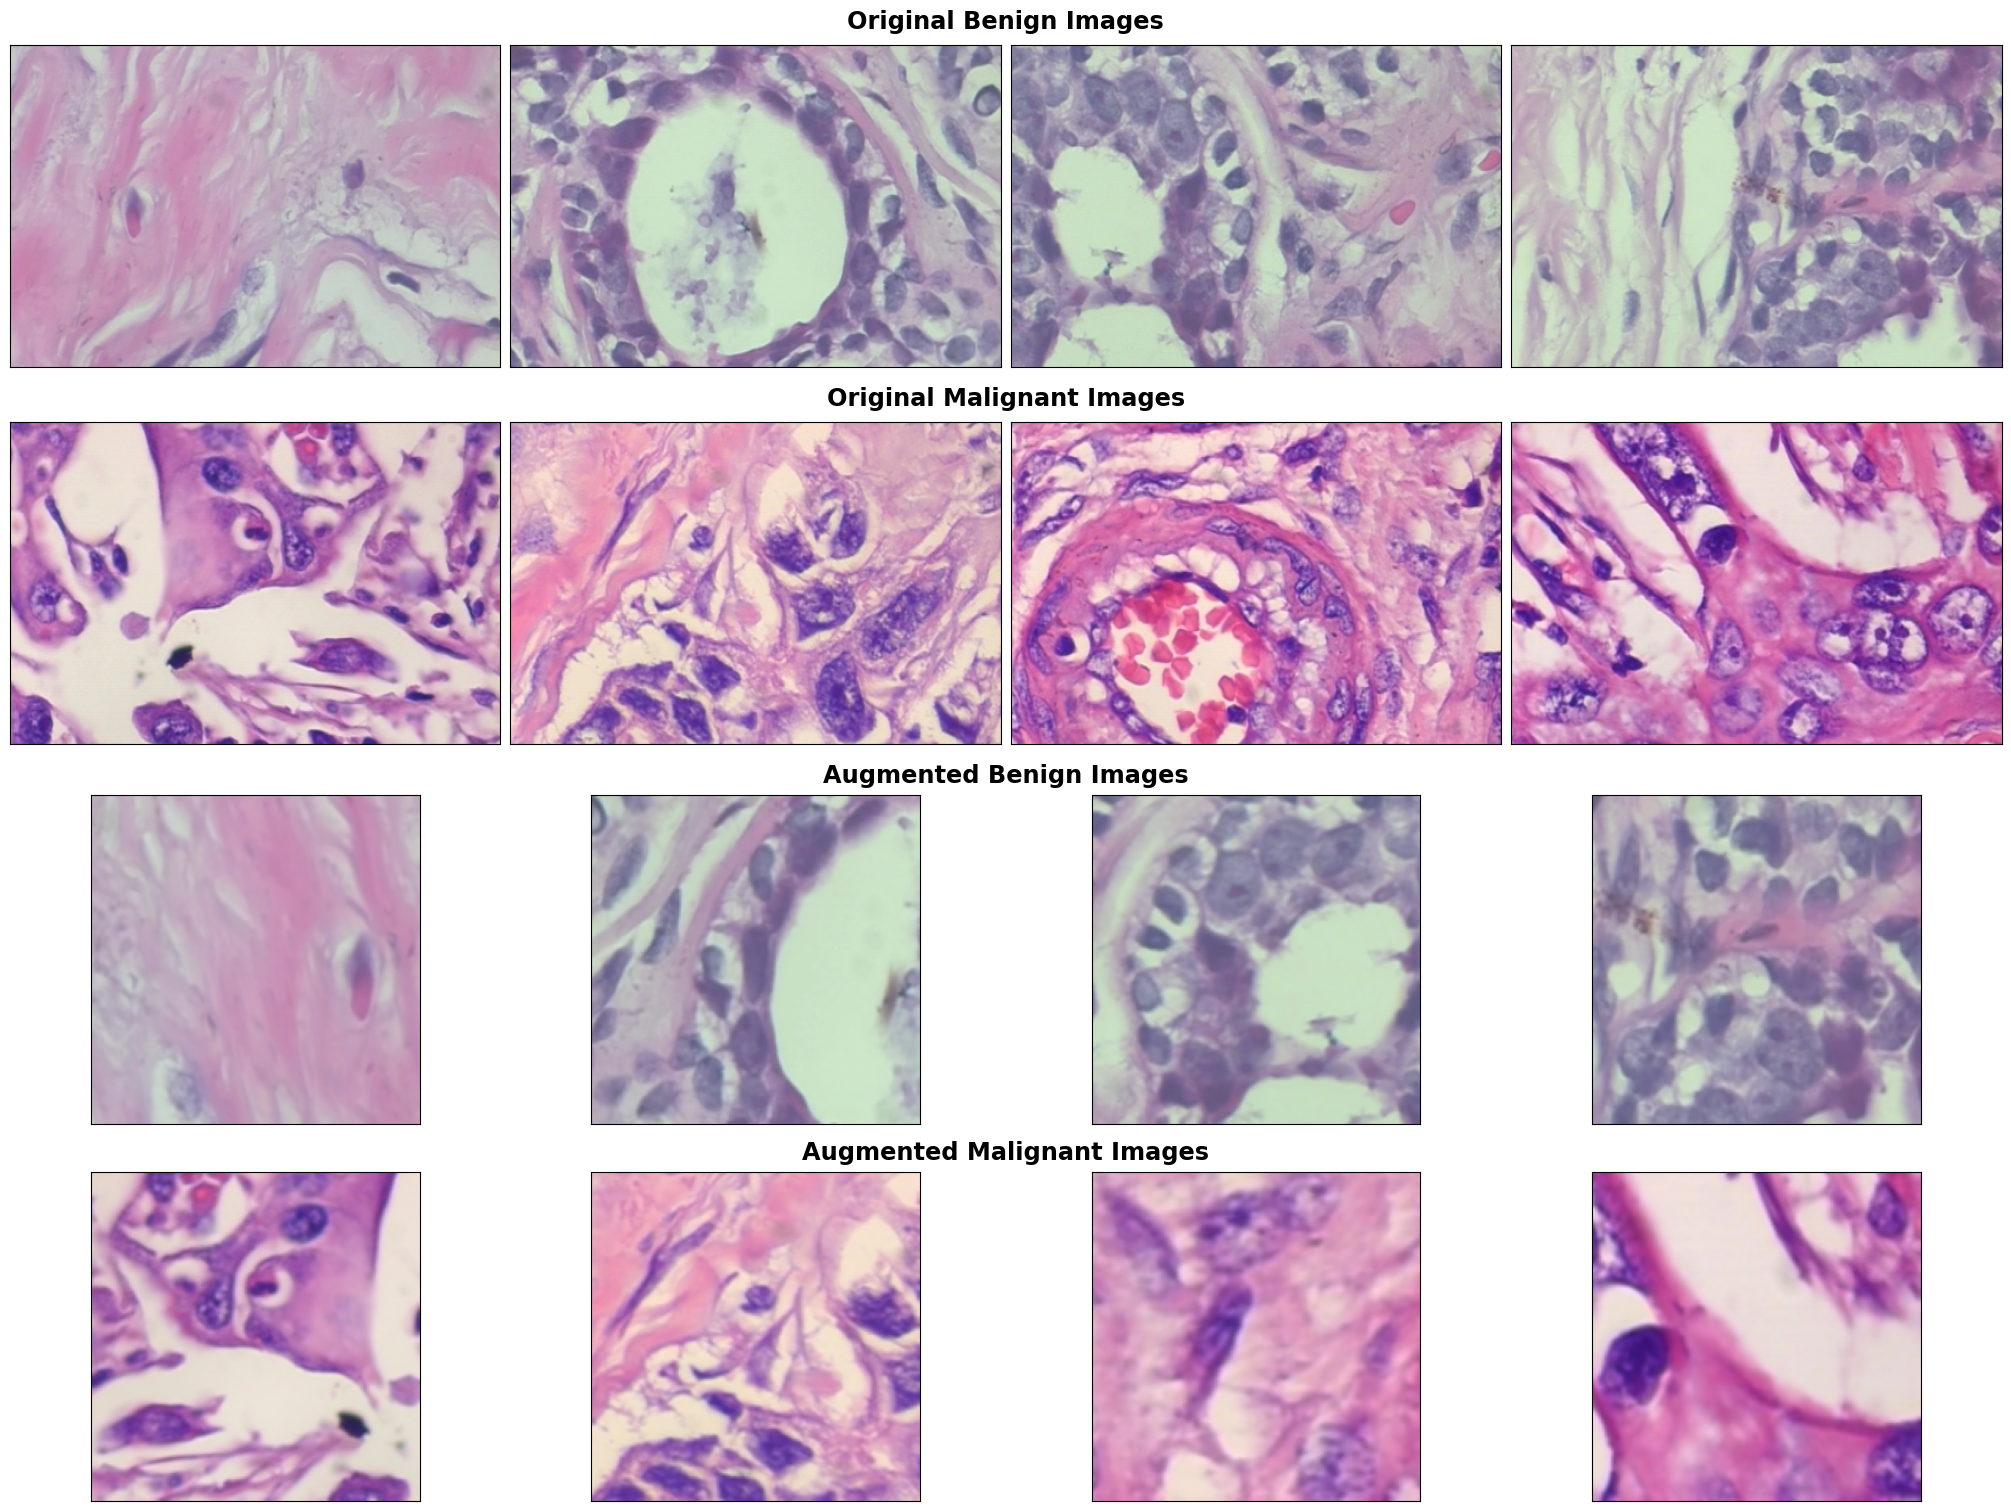

In [8]:
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(size=IMAGE_SHAPE, antialias=True),
    transforms.RandomHorizontalFlip(0.5),
    transforms.GaussianBlur(kernel_size=(3, 3))
])

# Initialize Original and Augmented Images
original_images = datasets.ImageFolder(root='data/train')
example_augmented_images = datasets.ImageFolder(root='data/train', transform=transform_aug)

# Save 4 samples of each class from the Original and Augmented pools
NO_SAMPLES = 4
THRESHOLD_MALIGNANT = 371
benign_examples, malignant_examples = [], []
benign_aug_examples, malignant_aug_examples = [], []

for i in range(NO_SAMPLES):
    benign_image, _ = original_images[i]
    malignant_image, _ = original_images[THRESHOLD_MALIGNANT + i]

    benign_aug_image, _ = example_augmented_images[i]
    malignant_aug_image, _ = example_augmented_images[THRESHOLD_MALIGNANT + i]
    
    benign_examples.append(benign_image)
    malignant_examples.append(malignant_image)

    benign_aug_examples.append(benign_aug_image)
    malignant_aug_examples.append(malignant_aug_image)

concat_examples = [
    benign_examples, 
    malignant_examples,
    benign_aug_examples,
    malignant_aug_examples
]

# Plot
NO_CATEGORIES = 4
TITLES = [
    'Original Benign Images', 
    'Original Malignant Images', 
    'Augmented Benign Images', 
    'Augmented Malignant Images'
]

fig = plt.figure(figsize=(20, 15), constrained_layout=True)
subfigs = fig.subfigures(NO_CATEGORIES, 1)

for idx, (subfig, title) in enumerate(zip(subfigs, TITLES)):
    subfig.suptitle(title, size='xx-large', weight='bold')
    axes = subfig.subplots(1, NO_SAMPLES)

    for image, ax in zip(concat_examples[idx], axes):
        ax.imshow(image)

        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

## Network Initialization - ResNet50

In [9]:
model = nn.Sequential(
    resnet50(weights=ResNet50_Weights.DEFAULT),
    nn.Linear(1000, 1),
    nn.Sigmoid(),
    nn.Flatten(0)
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training & Validation

### Implementation

In [10]:
NUM_EPOCHS = 30
best_val_loss = np.inf
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    train_losses_per_epoch = []
    no_correct_guesses_train = 0

    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels.float())
        loss.backward()

        train_losses_per_epoch.append(loss.item())

        optimizer.step()

        no_correct_guesses_train += (output.round() == labels).sum().item()

    val_losses_per_epoch = []
    no_correct_guesses_val = 0

    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
    
            output = model(images)
            
            loss = criterion(output, labels.float())
            val_losses_per_epoch.append(loss.item())

            no_correct_guesses_val += (output.round() == labels).sum().item()

    train_loss_per_epoch = np.mean(train_losses_per_epoch)
    val_loss_per_epoch = np.mean(val_losses_per_epoch)

    train_accuracy = no_correct_guesses_train * 100 / train_len
    val_accuracy = no_correct_guesses_val * 100 / val_len

    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}", end=', ')
        print(f"Training Loss: {round(train_loss_per_epoch, 2)}", end=', ')
        print(f"Training Accurracy: {round(train_accuracy, 2)}%", end=', ')
        print(f"Validation Loss: {round(val_loss_per_epoch, 2)}", end=', ')
        print(f"Validation Accurracy: {round(val_accuracy, 2)}%")

    train_losses.append(train_loss_per_epoch)
    val_losses.append(val_loss_per_epoch)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        torch.save(model.state_dict(), 'best-model-params.pt')

Epoch: 2/30, Training Loss: 0.19, Training Accurracy: 92.4%, Validation Loss: 0.13, Validation Accurracy: 94.31%
Epoch: 4/30, Training Loss: 0.1, Training Accurracy: 96.34%, Validation Loss: 0.12, Validation Accurracy: 96.15%
Epoch: 6/30, Training Loss: 0.11, Training Accurracy: 95.89%, Validation Loss: 0.09, Validation Accurracy: 96.51%
Epoch: 8/30, Training Loss: 0.05, Training Accurracy: 98.23%, Validation Loss: 0.07, Validation Accurracy: 97.25%
Epoch: 10/30, Training Loss: 0.07, Training Accurracy: 97.89%, Validation Loss: 0.06, Validation Accurracy: 98.17%
Epoch: 12/30, Training Loss: 0.07, Training Accurracy: 97.6%, Validation Loss: 0.08, Validation Accurracy: 96.88%
Epoch: 14/30, Training Loss: 0.04, Training Accurracy: 98.69%, Validation Loss: 0.12, Validation Accurracy: 96.33%
Epoch: 16/30, Training Loss: 0.05, Training Accurracy: 98.12%, Validation Loss: 0.06, Validation Accurracy: 97.61%
Epoch: 18/30, Training Loss: 0.05, Training Accurracy: 98.34%, Validation Loss: 0.1, Va

### Plotting Losses & Accuracies

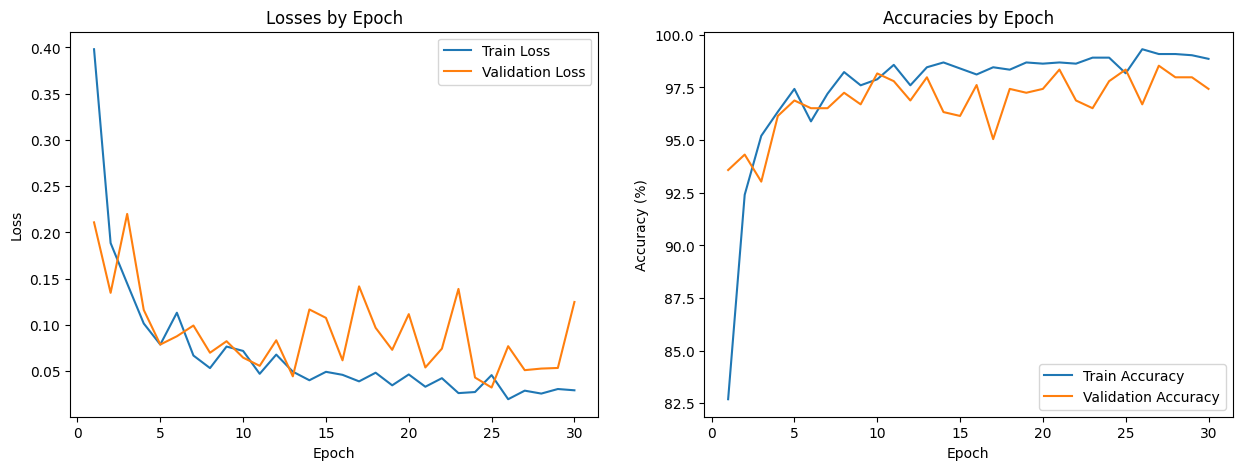

In [11]:
x = range(1, NUM_EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x, train_losses, label='Train Loss')
ax1.plot(x, val_losses, label='Validation Loss')

ax2.plot(x, train_accuracies, label='Train Accuracy')
ax2.plot(x, val_accuracies, label='Validation Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')

ax1.title.set_text("Losses by Epoch")
ax2.title.set_text("Accuracies by Epoch")

ax1.legend()
ax2.legend()

plt.show()

## Testing

### Implementation

In [12]:
y_pred, y_true = np.array([]), np.array([])

model.eval()
model.load_state_dict(torch.load('best-model-params.pt'))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)

        y_pred = np.append(y_pred, output.cpu().round())
        y_true = np.append(y_true, labels.cpu())

### Metrics

In [18]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
fnr = det_curve(y_true, y_pred)[1][1]

# Create DataFrame with metrics
metrics = [accuracy, precision, recall, f1, fnr]
metrics = [f"{round(score * 100, 1)}%" for score in metrics]

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Negative Rate']
metrics_labels = ['Metric', 'Value']

values = zip(metrics_names, metrics)
metrics_df = pd.DataFrame(data=values, columns=metrics_labels)
metrics_df = metrics_df.style.hide(axis='index')

metrics_df

### Confusion Matrix

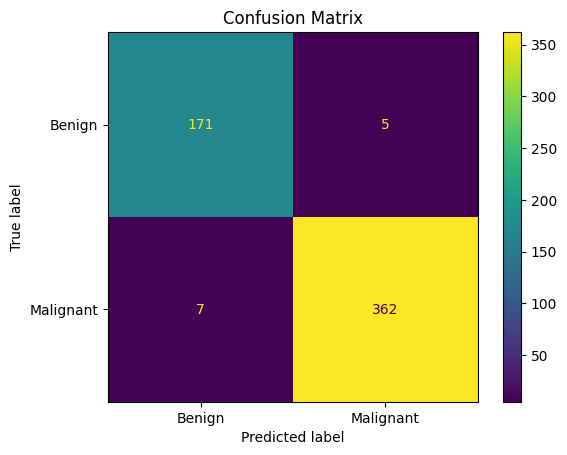

In [14]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

disp.plot()
disp.ax_.set_title("Confusion Matrix");